# Using mhdx_tools Part 3: Factorization and Generating HDX Time Series 
***

**The purpose of this notebook is to provide explanation and usage examples for the second half of the mhdx_tools.pipeline subpackage: the generate_tensor_ics and optimize_paths modules.**

>These modules use the tensor outputs from the extract_timepoint_tensors and library_info to process and deconvolute tensors, and select IsotopeClusters for a best-estimate hdx mass-addition time series.   

**The generate_tensor_ics module processes an input tensor and returns a list of IsotopeCluster objects identified from the source m/Z data.**

>The module is a wrapper for the TensorGenerator processing-class, itself a wrapper for the DataTensor data-class. The layers of abstraction simplify user input and interaction.

>The IsotopeClusters returned from the module are pooled together with those from other charge states of the same hdx time point to form the candidate-pool of signals that the optimize_paths module will chose from. 

**The optimize_paths module takes all IsotopeCluster objects from all charge-states and all hdx time points of an rt-group and returns the winning best-estimate hdx mass-addition time series for that rt-group.**

>The module bootstraps a set of possible mass-addition curves, and populates them with the closest input ICs. Then these 'paths' are greedily optimized by exchanging the one IC per-iteration that gives the best improvement on a set of score terms until the scores cannot be improved.

> The 'path' (series of IsotopeCluster objects) with the best score is saved as the '.winner' and the top runers-up are saved as '.runners'.

**The main output of the pipeline modules is the best-estimate hdx-mass-addition timeseries, contained in the PathOptimizer object as .winners, a list of IsotopeCluster objects. This is used in the estimation of per-residue exchange rates and $\Delta G_{unfolding}$ of library proteins.**

In [11]:
import os
import sys
import yaml
import glob
import numpy as np
import pandas as pd
import seaborn as sns

# Set matplotlib backend to work in jupyter.
import matplotlib
# matplotlib.use("nbAgg") # best for windows but works on Mac
matplotlib.use("MacOSX") # best for notebooks on Mac
import matplotlib.pyplot as plt
%matplotlib inline

# Make the Jupyter environment see workflow/scripts/.
sys.path.append("/".join(os.getcwd().split("/")[:-1])+"/workflow/scripts") # default 'path/to/mhdx_tools-Pipeline/workflow/scripts/'
library_info = pd.read_json("../resources/library_info/library_info.json")
names_and_seqs = pd.read_csv("../resources/library_info/new_HX_order.csv")
config = yaml.load(open("../config/config.yaml", "rb").read(), Loader=yaml.FullLoader)

# Load and alias main functions of preprocessing modules
from mhdx_tools.pipeline.idotp_check import main as idotp_check
from mhdx_tools.pipeline.idotp_filter import main as idotp_filter
from mhdx_tools.pipeline.extract_timepoint_tensors import main as extract_timepoint_tensors
from mhdx_tools.pipeline.generate_tensor_ics import main as generate_tensor_ics
from mhdx_tools.pipeline.optimize_paths import main as optimize_paths

from mhdx_tools.io import limit_read, limit_write, optimize_paths_inputs

**Here we consider groups of charged species together as an 'rt-group': a group of all the observed charge states of a library protein, clustered in LC retention time.**<br>
This is necessary to limit the size of the LC extraction window, as our designed proteins have been observed to have bimodal elution profiles. Clustering by elution-time can produce several rt-groups for each library protein, but these can be filtered with the idotp_check module to reduce computational load. RT-group names are assigned during the creation of the library_info.csv, and here we create sub-dataframes from library_info for each rt_group.

In [12]:
# Divide library_info into rt-group level dataframes
lib_names = list(set(library_info["name"].values))
lib_names = sorted(lib_names, key=lambda i: float(i.split("_")[-1]))

rt_group_dfs = {}
for name in lib_names:
    rt_group_dfs[name] = library_info.loc[library_info["name"]==name]

In [15]:
# Select an rt-group by its lib_names index (sorted by LC-elution time), generate expected output filenames.
rt_group_name_idx = 999
indices_of_interest = rt_group_dfs[lib_names[rt_group_name_idx]]["Unnamed: 0"].values
desired_outputs = ["../resources/tensors/"+str(idx)+"_180604_Mix2_MES_nonlin_UN.mzML.gz.cpickle.zlib" for idx in indices_of_interest]

# Check if expected files are present, if not generate them. 
if all([len(list(glob.glob("../resources/tensors/"+str(idx)+"_*UN.*"))) > 0 for idx in indices_of_interest]): # only files from the replicate being used 
    rt_group_tensor_filenames = [fn for idx in indices_of_interest for fn in list(glob.glob("../resources/tensors/"+str(idx)+"_*"))]
    rt_group_undeut_filenames = [fn for fn in rt_group_tensor_filenames if "UN." in fn]

KeyError: 'Unnamed: 0'

In [13]:
rt_group_name_idx = 999

## Cleaning and deconvoluting extracted signals

**The generate_tensor_ics pipeline module is meant to fully abstract the signal processsing of the extracted tensors.** 

>Usually the only output is what will be used in generating the hdx-mass-addition time series: the list of IsotopeCluster objects identified from the input tensor. However in python contexts where the main function can be exposed (like this notebook), the return_flag argument can be used to return the TensorGenerator object from generate_tensor_ics. The TensorGenerator object contains a DataTensor object: the source of the IsotopeCluster objects, and more information than would be available with only the IsotopeCluster outputs. 

In [14]:
help(generate_tensor_ics)

Help on function main in module mhdx_tools.pipeline.generate_tensor_ics:

main(library_info_path, tensor_input_path, timepoints_dict, normalization_factors, isotope_clusters_out_path=None, factor_out_path=None, factor_plot_output_path=None, ic_plot_output_path=None, return_flag=False, gauss_params=(3, 1), n_factors=15, filter_factors=False, factor_rt_r2_cutoff=0.91, factor_dt_r2_cutoff=0.91, ic_peak_prominence=0.1, auto_ic_peak_width=True, ic_peak_width=2, ic_rel_height_filter=True, ic_rel_height_filter_baseline=0.1, ic_rel_height_threshold=0.1)
    Performs nonnegative tensor factorization to deconvolute input tensor, identifies IsotopeCluster objects, 
    and optionally returns or writes output list of IsotopeClusters.
    
    Args:
        library_info_path (str): path/to/library_info.json
        tensor_input_path (str): path/to/tensor.cpickle.zlib
        timepoints_dict (dict): dictionary with 'timepoints' key containing list of hdx timepoints in integer seconds, which are keys

In [12]:
# Use the return flag and a list comprehension to build a list of TensorGenerator objects from one undeuterated MS run for one rt-group. 
# generate_tensor_ics automatically performs gaussian filtering on the LC and IMS dimensions, and performs tensor factorization to deconvolute signals.
undeut_tgs = []
for tensor_filename in rt_group_undeut_filenames:
    # Use 'TensorGenerator' key on the return to get object out of returned dictionary.
    undeut_tgs.append(generate_tensor_ics(library_info_path="../resources/library_info/library_info.csv", tensor_input_path=tensor_filename, timepoints_dict=config, isotope_clusters_out_path=None, return_flag=True)["TensorGenerator"])

Pre-Initialization: 0.16301727294921875
Post-Initialization: 0.17884445190429688
0 Start Process Memory (GB): 0.1788482666015625


/Users/rwl0960/Documents/hdx/mhdx_tools-Pipeline/workflow/scripts/mhdx_tools/datatypes.py:42: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



1 Read Params Process Memory (GB): 0.1823883056640625
2 Zeroing Process Memory (GB): 0.1823883056640625
3 Pre-Factorization Process Memory (GB): 0.1823883056640625
4 13 Factors  Start Process Memory (GB): 0.1823883056640625
Irrelevant number of sparsity coefficient (different from the number of modes), they have been set to None.
Irrelevant number of normalization booleans (different from the number of modes), they have been set to False.


/Users/rwl0960/opt/anaconda3/envs/dask_lab/lib/python3.7/site-packages/nn_fac/ntf.py:308: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



4 13 Factors  End Process Memory (GB): 0.20264053344726562
5 12 Factors  Start Process Memory (GB): 0.20267868041992188
Irrelevant number of sparsity coefficient (different from the number of modes), they have been set to None.
Irrelevant number of normalization booleans (different from the number of modes), they have been set to False.
5 12 Factors  End Process Memory (GB): 0.20635223388671875
6 11 Factors  Start Process Memory (GB): 0.20635223388671875
Irrelevant number of sparsity coefficient (different from the number of modes), they have been set to None.
Irrelevant number of normalization booleans (different from the number of modes), they have been set to False.
6 11 Factors  End Process Memory (GB): 0.20635223388671875
7 10 Factors  Start Process Memory (GB): 0.20635223388671875
Irrelevant number of sparsity coefficient (different from the number of modes), they have been set to None.
Irrelevant number of normalization booleans (different from the number of modes), they have be

In [13]:
undeut_tgs # stores the list of TensorGenerators

In [14]:
# TensorGenerator objects store a DataTensor as TensorGenerator.DataTensor.
undeut_tgs[0].DataTensor

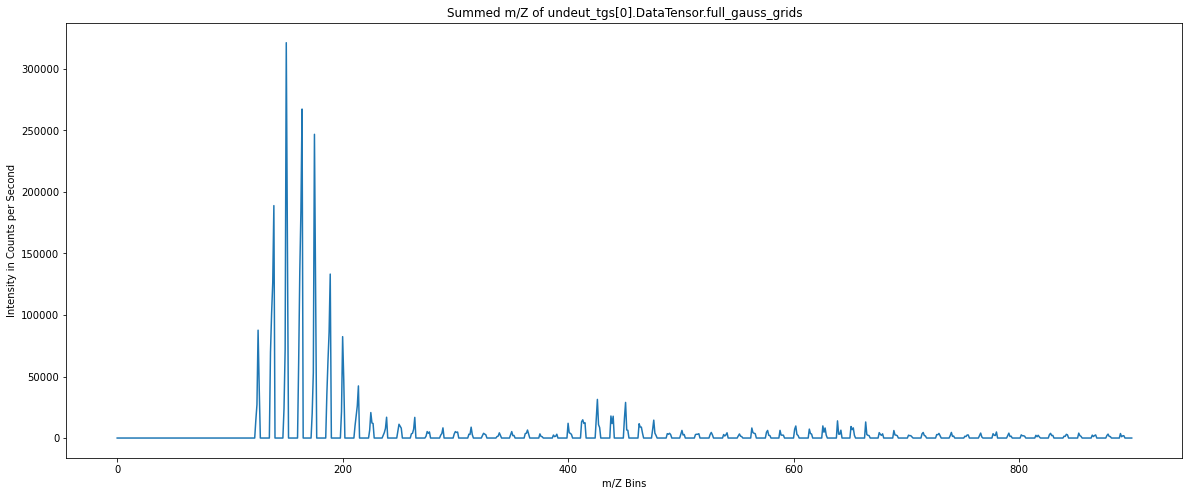

In [15]:
# DataTensor.full_gauss_grids contains the processed 3D numpy array of LC-IMS-MS intensity data.
fig = plt.figure(figsize=(20,8))
ax1=fig.add_subplot(111)
plt.plot(np.sum(undeut_tgs[0].DataTensor.full_gauss_grids, axis=(0,1)))
ax1.set(title="Summed m/Z of undeut_tgs[0].DataTensor.full_gauss_grids", xlabel="m/Z Bins", ylabel="Intensity in Counts per Second")
plt.show()
plt.close()

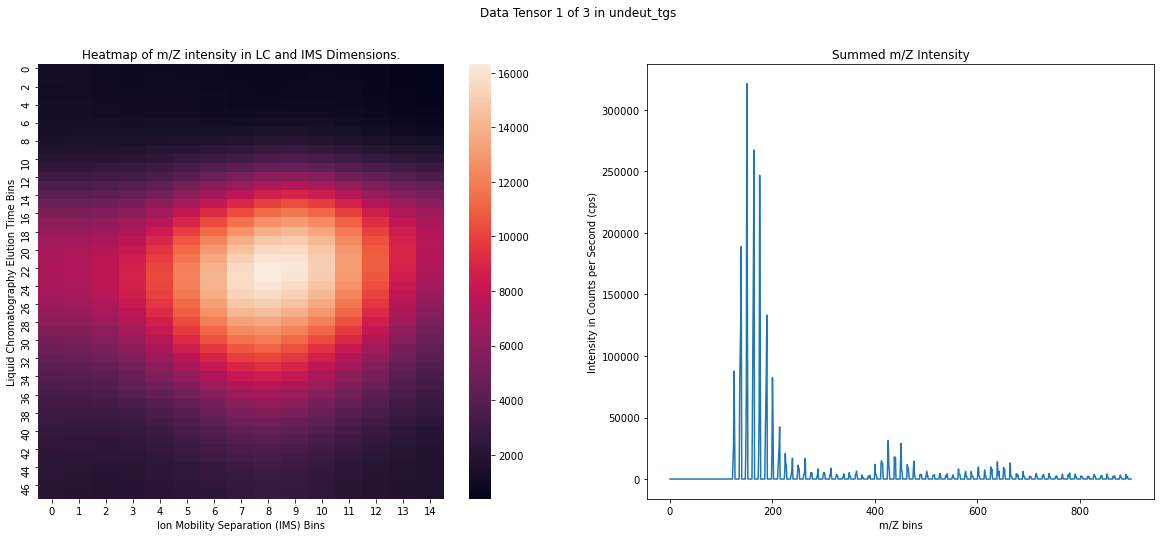

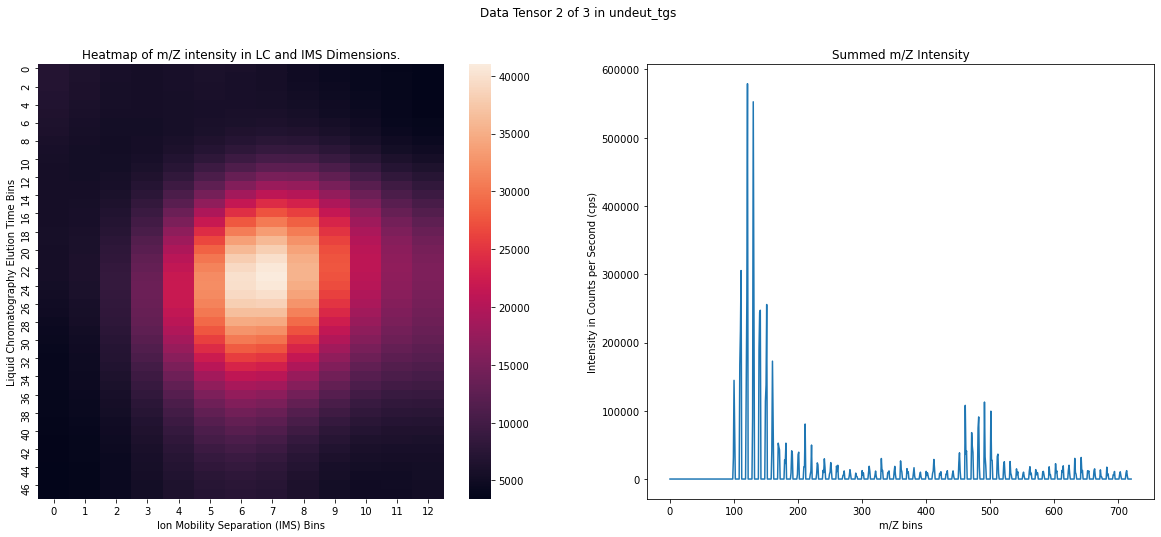

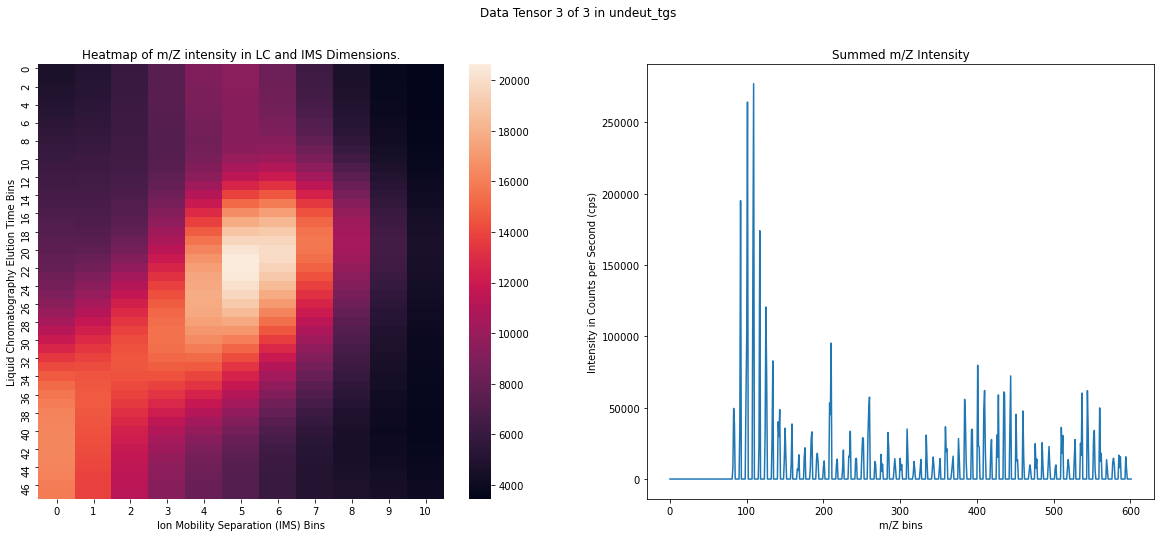

In [16]:
# Heatmaps and mass spectra for undeut_tgs
for i in range(len(undeut_tgs)):
    fig = plt.figure(figsize=(20,8))
    fig.suptitle("Data Tensor "+str(i+1)+" of "+str(len(undeut_tgs))+" in undeut_tgs")
    
    ax1 = fig.add_subplot(121)
    ax1 = sns.heatmap(np.sum(undeut_tgs[i].DataTensor.full_gauss_grids, axis=2), ax=ax1)
    ax1.set(title="Heatmap of m/Z intensity in LC and IMS Dimensions", xlabel="Ion Mobility Separation (IMS) Bins", ylabel = "Liquid Chromatography Elution Time Bins")
    
    ax2 = fig.add_subplot(122)
    plt.plot(np.sum(undeut_tgs[i].DataTensor.full_gauss_grids, axis=(0,1)))
    ax2.set(title="Summed m/Z Intensity", xlabel="m/Z bins", ylabel="Intensity in Counts per Second (cps)")

**The DataTensor object performs gaussian smoothing and tensor-factorization to clean and deconvolute the input.**<br>
This is useful in our experimental setup where we test many designs of a few structural folds, and signals can be crowded in separation space. Convoluted signals in the DataTensor are resolved by tensor factorization, and the resulting factors are packaged as instances of the Factor class and stored as a list in the  DataTensor.factors attribute. 

In [ ]:
for i in range(len(undeut_tgs)):
    fig = plt.figure(figsize=(20,8))
    fig.suptitle("DataTensor "+str(i)+" of "+str(len(undeut_tgs)))
    ax1 = fig.add_subplot(121)
    ax1 = sns.heatmap(np.sum(undeut_tgs[i].DataTensor.full_gauss_grids, axis=2), ax=ax1)
    ax1.set(title="Heatmap of m/Z Intensity in Extracted LC and IMS Region", xlabel="Ion Mobility Separation (IMS) Bins", ylabel = "Liquid Chromatography (LC) Elution Time Bins")

    ax2 = fig.add_subplot(122)
    ax2 = fig.add_subplot(122)
    plt.plot(np.sum(undeut_tgs[i].DataTensor.full_gauss_grids, axis=(0,1)))
    ax2.set(title="Sum of intensity in m/Z over LC and IMS", xlabel="m/Z bins", ylabel="Intensity in Counts per Second (cps)")
    
    for j in range(len(undeut_tgs[i].DataTensor.factors)):
        fig = plt.figure(figsize=(20,16))
        fig.suptitle("Tensor "+str(i)+ ", Factor "+str(j)+" of "+str(len(undeut_tgs[i].DataTensor.factors)))

        ax1 = fig.add_subplot(221)
        plt.plot(undeut_tgs[i].DataTensor.factors[j].mz_data)
        ax1.set(title="Heatmap of m/Z Intensity in Extracted LC and IMS Region", xlabel="Ion Mobility Separation (IMS) Bins", ylabel = "Liquid Chromatography (LC) Elution Time Bins")

        ax2 = fig.add_subplot(222)
        plt.plot(undeut_tgs[i].DataTensor.factors[j].integrated_mz_data)
        ax2.set(title="Summed m/Z Intensity", xlabel="m/Z bins", ylabel="Intensity in counts per second (cps)")
        
        ax3 = fig.add_subplot(223)
        plt.plot(undeut_tgs[i].DataTensor.factors[j].rts)
        ax3.set(title="Summed m/Z Intensity", xlabel="m/Z bins", ylabel="Intensity in counts per second (cps)")
        
        ax4 = fig.add_subplot(224)
        plt.plot(undeut_tgs[i].DataTensor.factors[j].dts)
        ax3.set(title="Summed m/Z Intensity", xlabel="m/Z bins", ylabel="Intensity in counts per second (cps)")

In [25]:
files = glob.glob("../resources/subtensor_ics/999_*")

In [30]:
un_fns = ["../resources/subtensor_ics/999_180604_Mix2_MES_nonlin_UN.mzML.gz.cpickle.zlib",
         "../resources/subtensor_ics/999_180604_Mix2_MES_nonlin_UN.mzML.gz.cpickle.zlib",
         "../resources/subtensor_ics/999_180604_Mix2_MES_nonlin_UN.mzML.gz.cpickle.zlib"
         ]

In [31]:
limit_read(un_fns[0])

ModuleNotFoundError: No module named 'LC_IM_MS_TensorAnalysis'

In [17]:
# Collect IsotopeClusters from all Factors of all undeuterated DataTensors
undeut_ics = []
for tg in undeut_tgs:
    for factor in tg.DataTensor.factors:
        for ic in factor.isotope_clusters:
            undeut_ics.append(ic)

LC-dimension labels:
[5.06829977 5.08521652 5.10211658 5.11901665 5.1359334  5.15283346
 5.16973352 5.1866498  5.20354986 5.22046661 5.23736668 5.25426674
 5.27118349 5.28808355 5.30499983 5.32189989 5.33879995 5.35571671
 5.37261677 5.38953352 5.40643311 5.42333317 5.44024992 5.45714998
 5.47406673 5.4909668  5.50786686 5.52478313 5.5416832  5.55859995
 5.57550001 5.59240007 5.60931683 5.62621689 5.64313316 5.66003323
 5.67693329 5.69385004 5.7107501  5.72766685 5.74456644 5.7614665
 5.77838326 5.79528332 5.81220007 5.82910013 5.84600019 5.86291647]

IMS-dimension labels:
[8.37950139 8.44875346 8.51800554 8.58725762 8.6565097  8.72576177
 8.79501385 8.86426593 8.93351801 9.00277008 9.07202216 9.14127424
 9.21052632 9.27977839 9.34903047]

m/Z labels:
[1276.40380859 1276.42380859] ... [1294.38380859 1294.40380859]





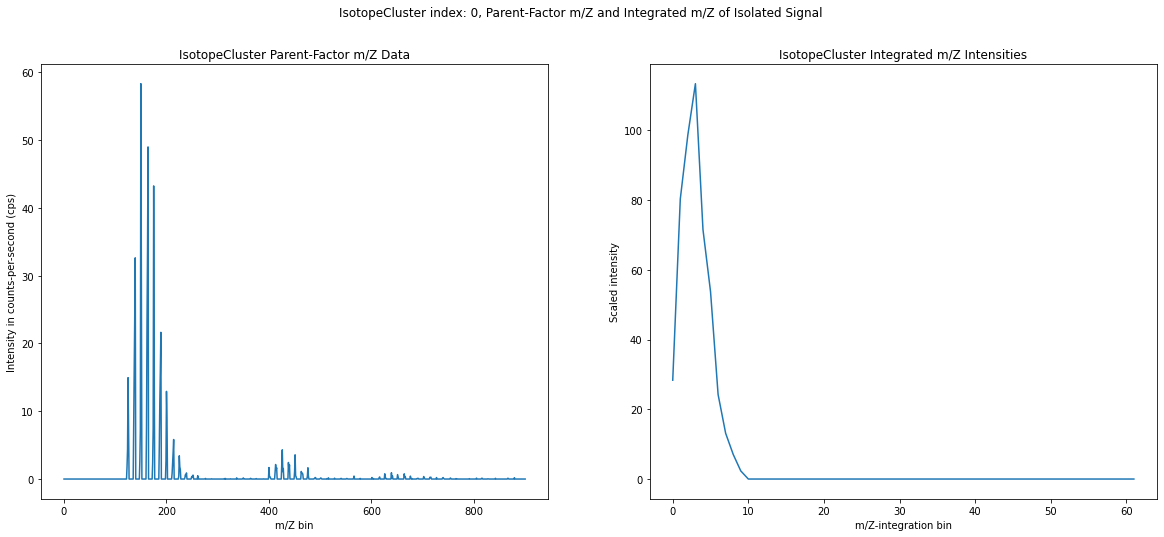

In [18]:
# Display IsotopeCluster data and dimension labels.
# The IsotopeCluster objects contain information about their parent factor, positions in each dimension, and processed m/Z signal.

my_ic_idx = 0
my_ic = undeut_ics[my_ic_idx]

print("LC-dimension labels:")
print(my_ic.retention_labels)
print("\nIMS-dimension labels:")
print(my_ic.drift_labels)
print("\nm/Z labels:")
print(str(my_ic.mz_labels[:2])+" ... "+str(my_ic.mz_labels[-2:])+"\n\n\n")

fig = plt.figure(figsize=(20,8))
plt.suptitle("IsotopeCluster index: "+str(my_ic_idx)+", Parent-Factor m/Z and Integrated m/Z of Isolated Signal")

ax1 = fig.add_subplot(121)
plt.plot(my_ic.factor_mz_data)
ax1.set(title="IsotopeCluster Parent-Factor m/Z Data", xlabel="m/Z bin", ylabel="Intensity in counts-per-second (cps)")

ax2 = fig.add_subplot(122)
plt.plot(my_ic.baseline_integrated_mz)
ax2.set(title="IsotopeCluster Integrated m/Z Intensities", xlabel="m/Z-integration bin", ylabel="Scaled intensity")

plt.show()
plt.close()

***
## Generating a best-estimate hdx-mass-addition time series

**The hdx time series estimation is performed by instances of the PathOptimizer class. They take in all IsotopeClusteres from all charge-states of an rt-group, sample a starting set of plausible mass-addition curves, and optimize those starting curves by scoring with reference to the undeuterated ground-truth signal.**

The mhdx_tools.pipeline.optimize_paths module simply wraps PathOptimizer class for simple, easy instantiation.  

In [19]:
help(optimize_paths)

Help on function main in module mhdx_tools.pipeline.optimize_paths:

main(library_info_path, all_tensor_input_paths, timepoints, return_flag=False, rt_group_name=None, old_data_dir=None, html_plot_out_path=None, winner_out_path=None, runner_out_path=None, undeut_ground_out_path=None, winner_scores_out_path=None, rtdt_com_cvs_out_path=None)
    Uses PathOptimzier class to generate best-estimate hdx-timeseries of IsotopeClusters for a given library protein.
    
    Args:
        library_info_path (str): path/to/library_info.csv
        all_tensor_input_paths (list of strings): list of paths/to/files.cpickle.zlib for all lists of IsotopeClusters from generate_tensor_ics.py
        timepoints (dict): dictionary with 'timepoints' key containing list of hdx timepoints in integer seconds, which are keys mapping to lists of each timepoint's replicate .mzML filenames 
        return_flag: option to return main output in python, for notebook context
        rt_group_name (str): library_info['na

In [20]:
# The io module function optimize_paths_inputs creates the flat list of IsotopeCluster-list files for an rt-group. This is sorted by the module.
ic_ins = optimize_paths_inputs(lib_names[rt_group_name_idx], library_info, config)
ic_ins = ["../"+fn for fn in ic_ins] # preprend ../ to adjust for working in /notebooks
print(len(ic_ins))

69


In [21]:
# Slow depending on the number of ICs input. 
# PathOptimizer.weak_pareto_dom_filter does some filtering on init, but may need more to be fast.

# Use the optimize_paths module on ICs from an rt-group to return a PathOptimizer object.
p1 = optimize_paths(
    "../resources/library_info/library_info.csv", 
    ic_ins, 
    config, 
    return_flag=True, 
    rt_group_name=lib_names[rt_group_name_idx], 
    html_plot_out_path="test_po_plot.html")["PathOptimizer"] # output is a dictionary, use known key

/Users/rwl0960/opt/anaconda3/envs/dask_lab/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



In [5]:
def optimize_paths_inputs(name, library_info, idotp_check_indices):
    # Pass inputs as fxn of rt-group name wildcard. Creates analyze_tensor() input filenames in fixed pattern, input tensor names include library_info.index and rt-group avg elution time.
    name_inputs = []
    for key in config["timepoints"]:
        if len(config[key]) > 1:
            for file in config[key]:
                passing_indices = [i for i in library_info.loc[library_info["name"]==name].index if i in idotp_check_indices]
                for idx in passing_indices:
                    name_inputs.append(
                        "resources/subtensor_ics/"
                        + str(idx)
                        + "/"
                        + str(idx)
                        + "_"
                        + file
                        + ".gz.cpickle.zlib"
                    )  
        else:
            file = config[key][0]
            passing_indices = [i for i in library_info.loc[library_info["name"]==name].index if i in idotp_check_indices]
            for idx in passing_indices:
                name_inputs.append(
                    "resources/subtensor_ics/"
                    + str(idx)
                    + "/"
                    + str(idx)
                    + "_"
                    + file
                    + ".gz.cpickle.zlib"
                )

In [9]:
df = pd.read_json("resources/library_info/checked_library_info.json")

ValueError: Expected object or value

In [6]:
optimize_paths_inputs()

TypeError: optimize_paths_inputs() missing 3 required positional arguments: 'name', 'library_info', and 'idotp_check_indices'